In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web

# **Stock Price Prediction**

Given last 50 days of tesla price and S&P500, plot next five days of predicted tesla closing stock price, compare with actual. Show your results using comparative graphs as done for the flights data in example shared earlier.

In [2]:
Tesla = web.DataReader('TSLA',data_source = 'yahoo', start = '2016-01-01', end = '2019-12-31') #Extract data from yahoo finance website for Tesla and S&P 500
SP500 = web.DataReader('^GSPC',data_source = 'yahoo', start = '2016-01-01', end = '2019-12-31')

#Check both lengths are same. If you pull data from different stock echanges, the length might be different depending on holidays
print(len(Tesla['Open']))
print(len(SP500['Open'])) 

#You may get any other  ticker by searching here https://finance.yahoo.com/quote/

1006
1006


In [3]:
SP500

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,2038.199951,1989.680054,2038.199951,2012.660034,4304880000,2012.660034
2016-01-05,2021.939941,2004.170044,2013.780029,2016.709961,3706620000,2016.709961
2016-01-06,2011.709961,1979.050049,2011.709961,1990.260010,4336660000,1990.260010
2016-01-07,1985.319946,1938.829956,1985.319946,1943.089966,5076590000,1943.089966
2016-01-08,1960.400024,1918.459961,1945.969971,1922.030029,4664940000,1922.030029
...,...,...,...,...,...,...
2019-12-24,3226.429932,3220.510010,3225.449951,3223.379883,1296540000,3223.379883
2019-12-26,3240.080078,3227.199951,3227.199951,3239.909912,2160680000,3239.909912
2019-12-27,3247.929932,3234.370117,3247.229980,3240.020020,2428670000,3240.020020


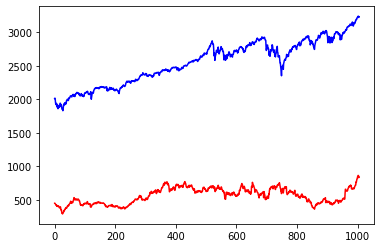

In [5]:
L = len(Tesla['Open'])
All_Data = np.concatenate((np.array(Tesla['Open']).reshape(L,1), np.array(Tesla['Close']).reshape(L,1), 
                           np.array(Tesla['High']).reshape(L,1), np.array(Tesla['Low']).reshape(L,1), np.array(Tesla['Volume']).reshape(L,1),
                           np.array(SP500['Open']).reshape(L,1), np.array(SP500['Close']).reshape(L,1),
                          np.array(SP500['High']).reshape(L,1), np.array(SP500['Low']).reshape(L,1), np.array(SP500['Volume']).reshape(L,1),), axis = 1)
plt.plot(np.array(Tesla['Close'])*10, 'r')  #Displayed at 10 times the scale for better visualization
plt.plot(np.array(SP500['Close']), 'b')


In [6]:
All_Data.shape

(1006, 10)

Use sequences of 8 input arrays taken from All_Data. Each input will be of of length 50  (Last 50 days) and will be used to predict next five days. Try RNN, LSTM or GRU

In [7]:
#creating train and test sets
train=All_Data[0:round(len(All_Data)*0.8),:]
valid=All_Data[round(len(All_Data)*0.8):,:]

In [8]:
#connverting dataset into x_train and y_train
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(All_Data)

x_train, y_train = [], []
for i in range(50,len(train)):
    x_train.append(scaled_data[i-50:i,:])
    y_train.append(scaled_data[i,1])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],10))

In [9]:
x_train.shape

(755, 50, 10)

In [10]:
y_train.shape

(755,)

In [11]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1:])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            12200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 32,451
Trainable params: 32,451
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train, y_train, epochs = 500)

Epoch 1/500
24/24 [==============================] - 5s 47ms/step - loss: 0.1032
Epoch 2/500
24/24 [==============================] - 1s 45ms/step - loss: 0.0057
Epoch 3/500
24/24 [==============================] - 1s 45ms/step - loss: 0.0039
Epoch 4/500
24/24 [==============================] - 1s 47ms/step - loss: 0.0035
Epoch 5/500
24/24 [==============================] - 1s 47ms/step - loss: 0.0034
Epoch 6/500
24/24 [==============================] - 1s 45ms/step - loss: 0.0033
Epoch 7/500
24/24 [==============================] - 1s 47ms/step - loss: 0.0028
Epoch 8/500
24/24 [==============================] - 1s 46ms/step - loss: 0.0032
Epoch 9/500
24/24 [==============================] - 1s 48ms/step - loss: 0.0026
Epoch 10/500
24/24 [==============================] - 1s 45ms/step - loss: 0.0024
Epoch 11/500
24/24 [==============================] - 1s 45ms/step - loss: 0.0026
Epoch 12/500
24/24 [==============================] - 1s 45ms/step - loss: 0.0024
Epoch 13/500
24/24 [=====

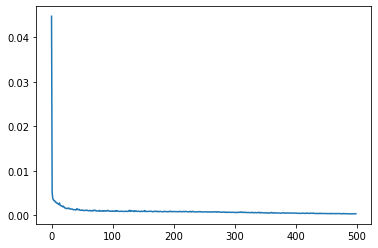

In [13]:
plt.plot(history.history['loss'])

In [14]:
#predicting future values, using past 50 values from the train data
inputs = All_Data[len(All_Data)-len(valid)- 50:]
inputs  = scaler.transform(inputs)

X_test = []
for i in range(50,inputs.shape[0]):
    X_test.append(inputs[i-50:i,:])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],10))
closing_price = model.predict(X_test)

#closing_price = scaler.inverse_transform(closing_price)

# creating temp variable to avoid invese transform error.
temp = np.zeros(shape=(len(closing_price), 10) )
temp[:,0] = closing_price[:,0]
closing_price = scaler.inverse_transform(temp)[:,0]

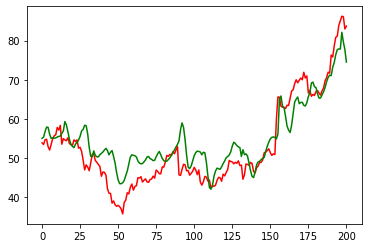

In [15]:
#for plotting

plt.plot(valid[:,1],'r')
plt.plot(closing_price,'g')